# 日本語テキストデータのクラスタリング結果の可視化

日本語テキストデータに非階層的クラスタリングを行い、その結果を、クラスタごとに単語の頻度の棒グラフで可視化。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# matplotlib: 日本語フォントの設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

# 日本語モデル
nlp = spacy.load('ja_core_news_lg')

# フィードデータの読み込み、確認
feeds = pd.read_csv('data/output_jp.csv')

# title と summary を結合
# str.cat() により複数列の文字列を結合
# - sep=' ': 間に挟む文字列
# - na_rep='': NaN は空文字列に変換（指定しないと結合結果が NaN になる）
feeds['text'] = feeds['title'].str.cat(feeds['summary'], sep='。', na_rep='')

# 不要になった列を削除した処理用の DataFrame
df = feeds.drop(['title', 'summary'], axis=1)

# 確認
df.head()

,url,text
0,https://www.nhk.or.jp/rss/news/cat0.xml,大阪 クリニック放火事件からまもなく1年 遺族が手記公開。大阪のビルでクリニックが放火され、...
1,https://www.nhk.or.jp/rss/news/cat0.xml,ワールドカップ 日本 森保監督 今大会の成果と今後の課題は。サッカーのワールドカップカタール...
2,https://www.nhk.or.jp/rss/news/cat0.xml,ロシア空軍基地に“ウクライナ軍の無人機攻撃” 大きな打撃か。ロシア国内の複数の空軍基地で爆発...
3,https://www.nhk.or.jp/rss/news/cat0.xml,サッカー日本代表 たどり着いたもう1つの“新しい景色”。11月20日に開幕したサッカーのワー...
4,https://www.nhk.or.jp/rss/news/cat0.xml,北朝鮮 日本海向け約100発砲撃 2日連続 “米韓両軍への警告”。韓国軍は、北朝鮮が6日、日...


### 日本語テキストに対する前処理

- 表記の正規化
- トークン化（形態素解析）
- ストップワードの除去
- 見出し語化

In [2]:
# 不要な単語を除去
# - ストップワード (is_stop)
# - いくつかの品詞
#     AUX: 助動詞
#     PUNCT: 句読点
#     SPACE: 空白文字
#     SYM: 記号
#     X: その他
# - うまく取り除けない単語や文字
stop_pos = ['AUX', 'PUNCT', 'SPACE', 'SYM', 'X']
stop_words = ['.']

def token_to_add(w):
    t = w.text    # 単語
    p = w.pos_    # 品詞
    l = w.lemma_  # 原型

    # ストップワードは None を返す
    if w.is_stop:
        return None
    if p in stop_pos:
        return None
    if l in stop_words:
        return None

    if len(l) == 0:
        return t
    return l

def preprocess(text):
    tokens = []
    
    for w in nlp(text):
        t = token_to_add(w)
        if t is not None:
            tokens.append(t)

    # トークンのリストを返す
    return tokens

### テキストのベクトル化

In [3]:
# BoW でベクトル化
vectorizer_bow = CountVectorizer(tokenizer=preprocess)
vector_bow = vectorizer_bow.fit_transform(df.text)

# TF-IDF でベクトル化
vectorizer_tfidf = TfidfVectorizer(tokenizer=preprocess)
vector_tfidf = vectorizer_tfidf.fit_transform(df.text)

### 非階層的クラスタリング

- TF-IDF の結果をクラスタリング

In [4]:
# クラスタ数
N_clusters = 10

# KMeans の初期化
clusters = KMeans(n_clusters=N_clusters).fit_predict(vector_tfidf)

# 結果を DataFrame にまとめる
df_cluster = pd.DataFrame(clusters, columns=['cluster'])

### クラスタごとの棒グラフ

- クラスタごとに、頻度とTF-IDFの棒グラフを描画

Cluster 0


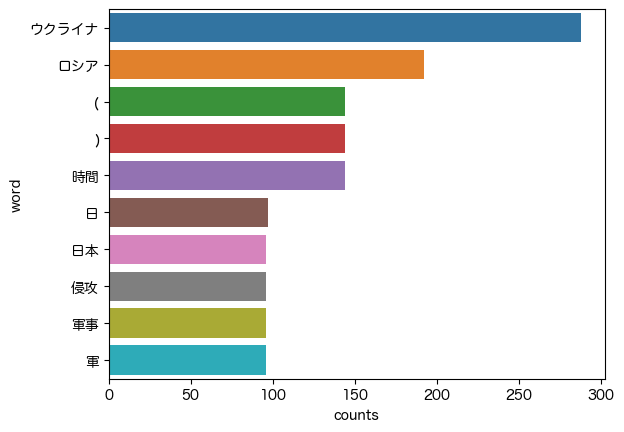

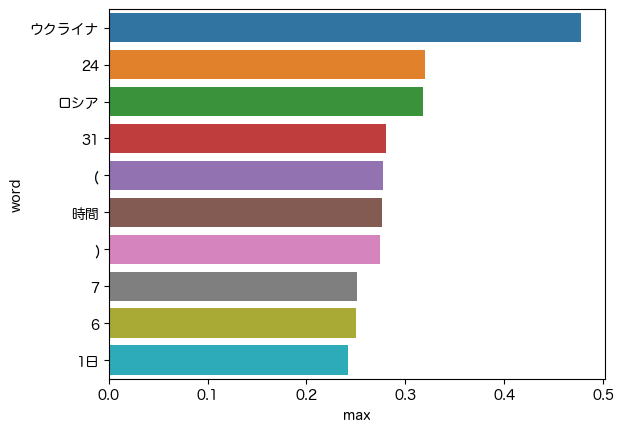

Cluster 1


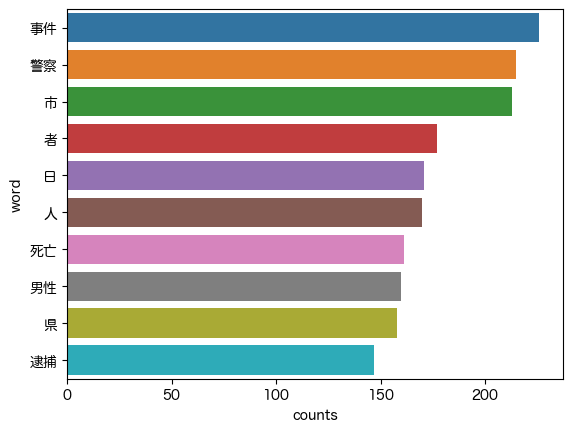

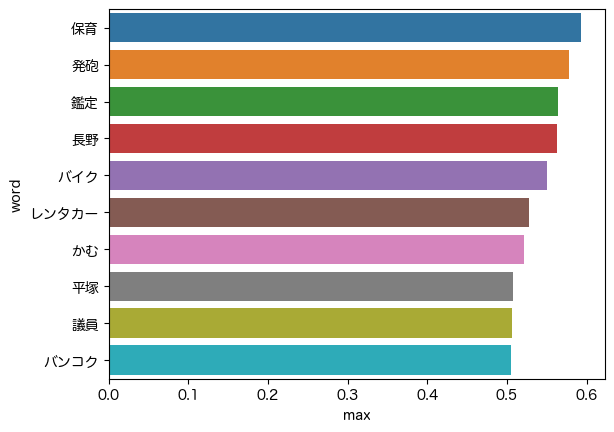

Cluster 2


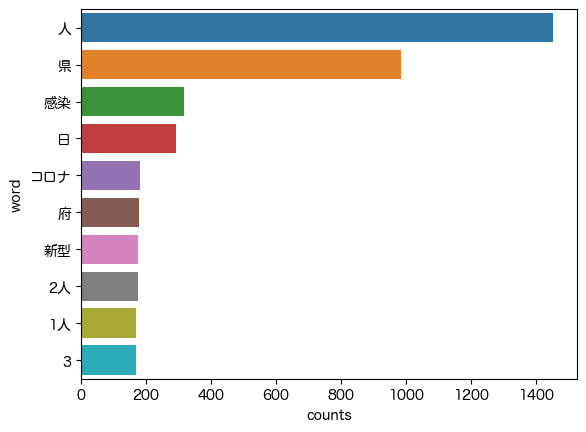

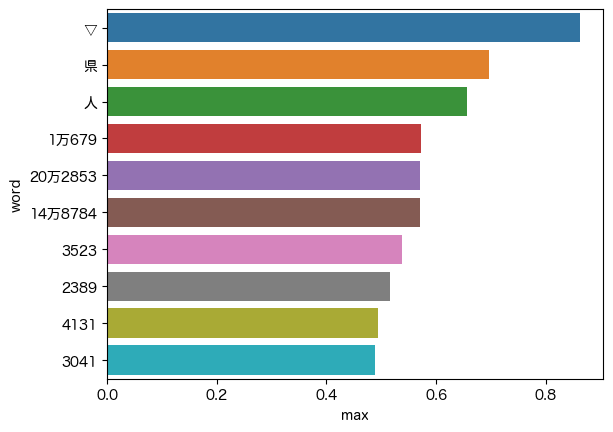

Cluster 3


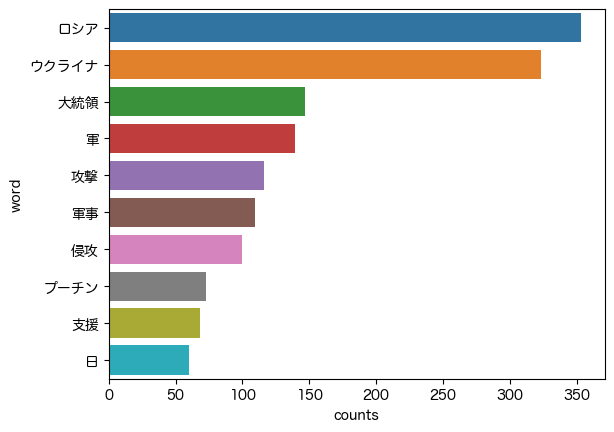

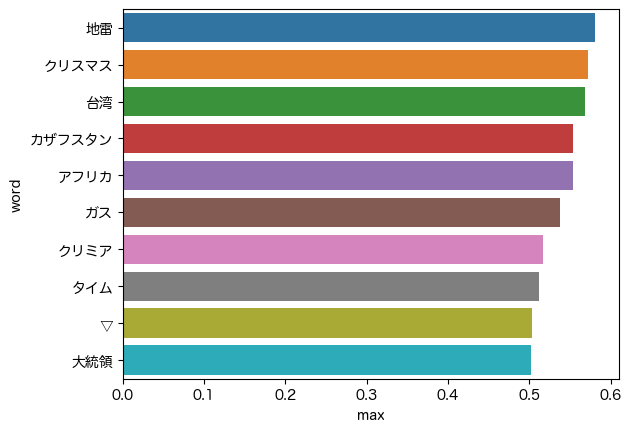

Cluster 4


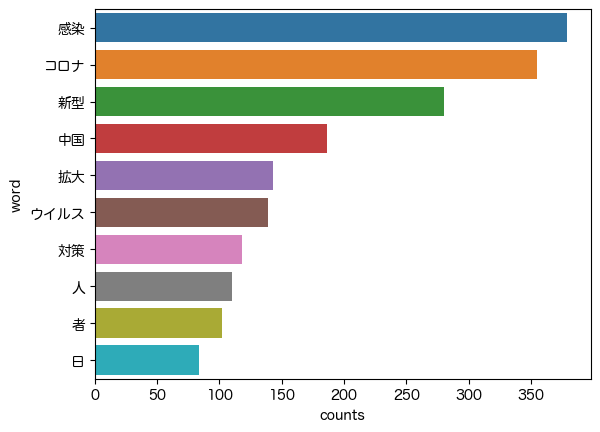

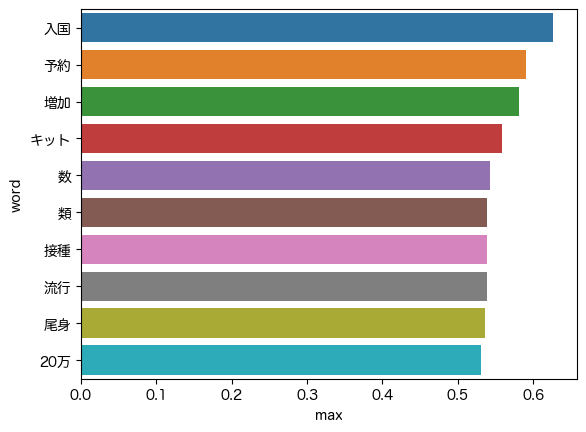

Cluster 5


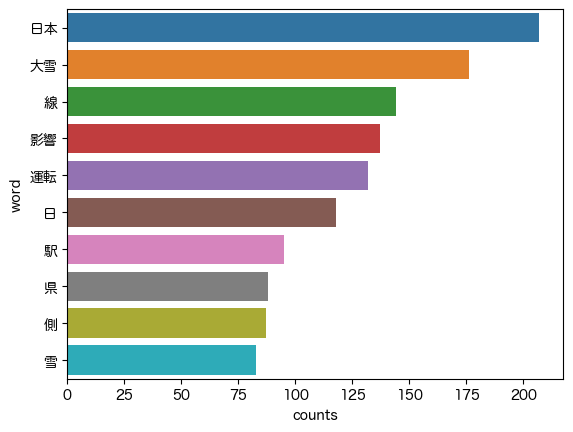

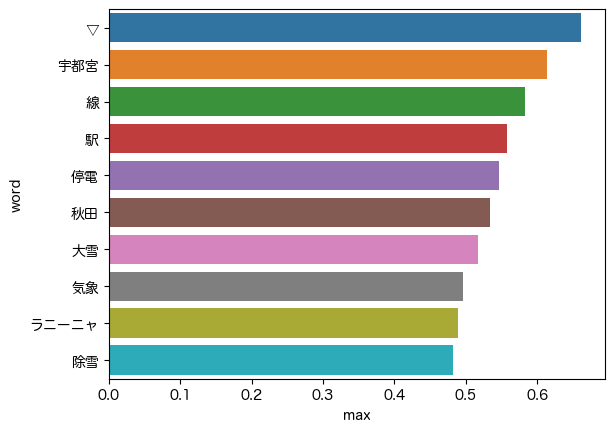

Cluster 6


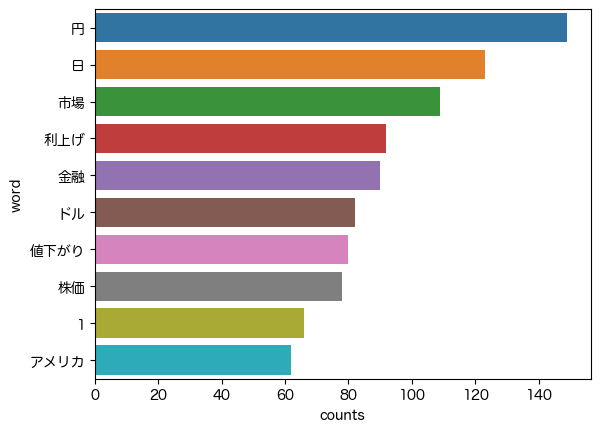

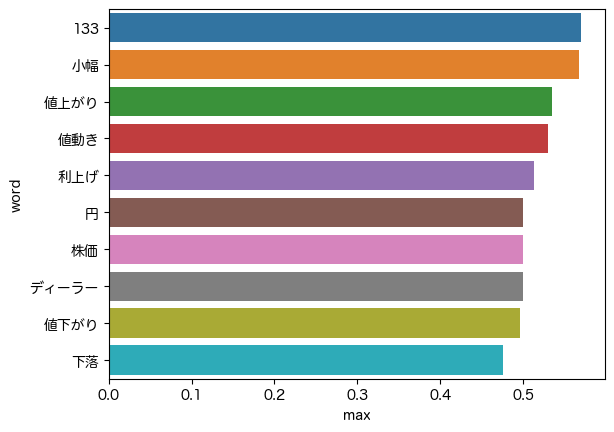

Cluster 7


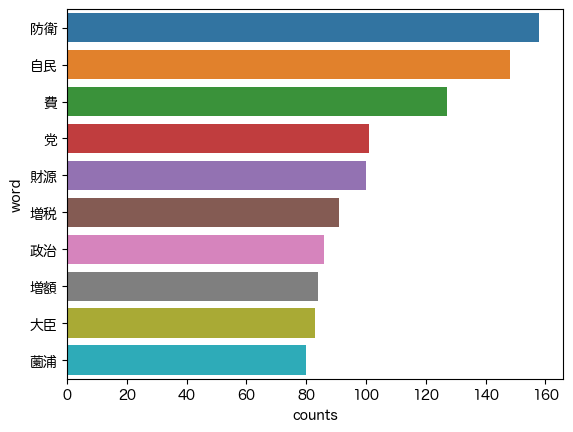

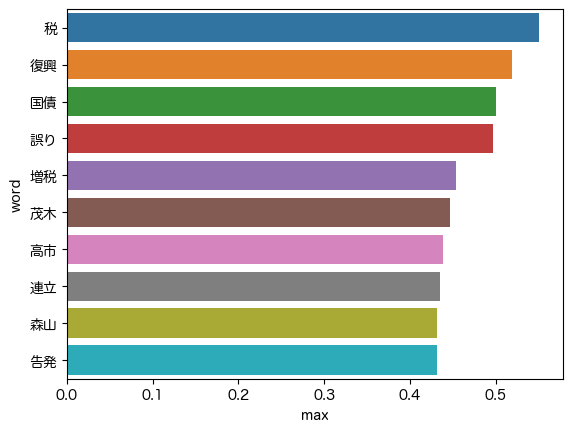

Cluster 8


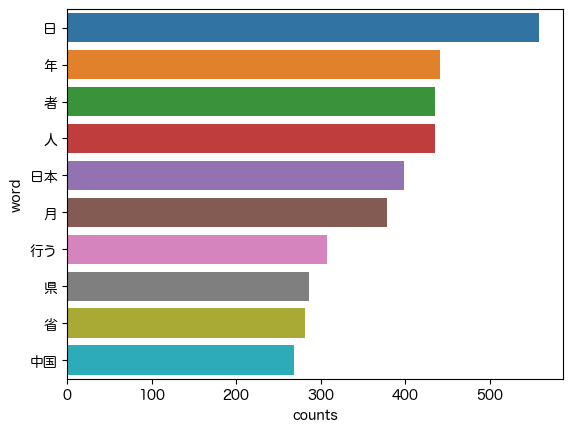

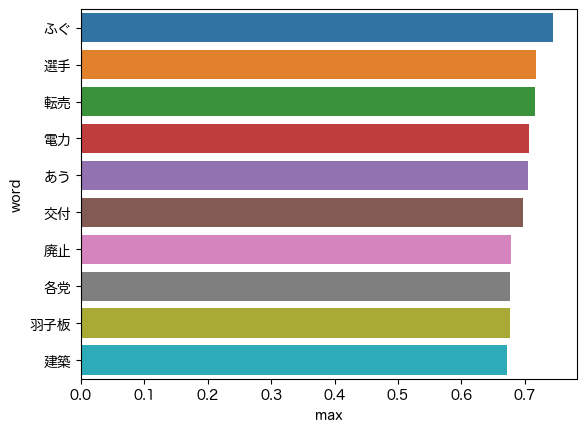

Cluster 9


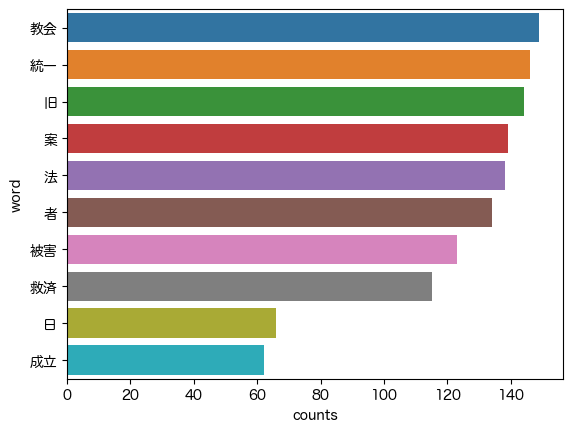

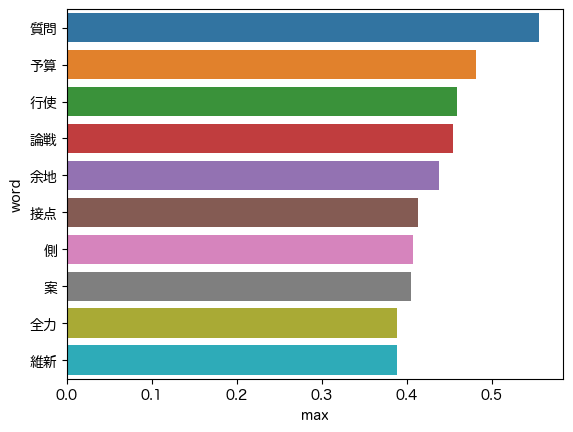

In [5]:
# 単語の DataFrame (BoW)
df_words_bow = pd.DataFrame(vectorizer_bow.get_feature_names_out())

# テキストを BoW ベクトル化した結果を DataFrame
df_vector_bow = pd.DataFrame.sparse.from_spmatrix(vector_bow)

# 単語の DataFrame (TF-IDF)
df_words_tfidf = pd.DataFrame(vectorizer_tfidf.get_feature_names_out())

# テキストをベクトル化した結果の DataFrame
df_vector_tfidf = pd.DataFrame.sparse.from_spmatrix(vector_tfidf)

for i in range(0, N_clusters):
    print('Cluster', i)
    _cdf = df_cluster[df_cluster['cluster'] == i]

    # 頻度の棒グラフ
    df_counts = pd.concat([df_words_bow, df_vector_bow.iloc[_cdf.index].sum()], axis=1)
    df_counts.columns=['word', 'counts']
    df_bar_bow = df_counts.sort_values('counts', ascending=False).head(10)
    sns.barplot(x=df_bar_bow.counts, y=df_bar_bow.word, orient='h')
    plt.show()
    
    # TF-IDFの棒グラフ
    _cdf_max = df_vector_tfidf.iloc[_cdf.index].max()
    df_max = pd.concat([df_words_tfidf, _cdf_max], axis=1)
    df_max.columns=['word', 'max']
    df_bar_tfidf = df_max.sort_values('max', ascending=False).head(10)
    sns.barplot(x=df_bar_tfidf['max'], y=df_bar_tfidf.word, orient='h')
    plt.show()